In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization,Dropout,Input,LayerNormalization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import (BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives,
                                       TrueNegatives, Precision, Recall, AUC, binary_accuracy,Accuracy,
                                       TopKCategoricalAccuracy, CategoricalAccuracy,SparseCategoricalAccuracy)
from tensorflow.keras.optimizers import Adam
from datasets import load_dataset
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer,TFDebertaForSequenceClassification,DebertaTokenizerFast)

2024-07-31 19:14:09.892372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 19:14:09.892450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 19:14:09.893713: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 19:14:09.902109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 19:14:10.866660: W tensorflow/compiler/tf2

## Data Prep

In [2]:
BATCH_SIZE=8

In [3]:
dataset=load_dataset("csv",
                       data_files="/mnt/c/Users/Lenovo/Desktop/DS/Datasets/20000-UtterancesTraining/20k.csv")

In [4]:
intents=list(set(dataset['train']['intent']))
dict_intents={intents[i]: i for i in range(len(intents))}
print(dict_intents)
print(len(intents))

{'registration_problems': 0, 'delivery_period': 1, 'edit_account': 2, 'track_order': 3, 'newsletter_subscription': 4, 'get_invoice': 5, 'cancel_order': 6, 'payment_issue': 7, 'delivery_options': 8, 'change_shipping_address': 9, 'track_refund': 10, 'switch_account': 11, 'review': 12, 'delete_account': 13, 'contact_human_agent': 14, 'create_account': 15, 'place_order': 16, 'set_up_shipping_address': 17, 'recover_password': 18, 'contact_customer_service': 19, 'check_payment_methods': 20, 'check_refund_policy': 21, 'complaint': 22, 'check_invoices': 23, 'get_refund': 24, 'check_cancellation_fee': 25, 'change_order': 26}
27


In [5]:
def preprocess(dataset):
  return {'utterance':dataset['utterance'],
          'intent':dict_intents[dataset['intent']]}

In [6]:
prep_dataset=dataset.map(preprocess)

Map:   0%|          | 0/21534 [00:00<?, ? examples/s]

In [7]:
model_id="microsoft/deberta-base"
tokenizer = DebertaTokenizerFast.from_pretrained(model_id)

In [8]:
def tokenizer_function(dataset):
  return tokenizer(dataset["utterance"],)

In [9]:
tokenized_dataset=prep_dataset.map(tokenizer_function)

Map:   0%|          | 0/21534 [00:00<?, ? examples/s]

In [10]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [11]:
tf_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids','attention_mask', 'intent'],
    shuffle=True, 
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

2024-07-31 19:14:21.487007: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-31 19:14:21.488251: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-31 19:14:21.488329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-31 19:14:21.498807: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-31 19:14:21.498902: I external/local_xla/xla/stream_executor

In [12]:
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'attention_mask':dataset['attention_mask'],},dataset['intent']

In [13]:
tf_dataset=tf_dataset.map(swap_positions)

In [14]:
train_dataset=tf_dataset.take(int(0.9*len(tf_dataset)))
val_dataset=tf_dataset.skip(int(0.9*len(tf_dataset)))

## Modelling

In [15]:
model=TFDebertaForSequenceClassification.from_pretrained(model_id,num_labels=len(intents))
model.summary()

All model checkpoint layers were used when initializing TFDebertaForSequenceClassification.

Some layers of TFDebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler', 'classifier', 'cls_dropout']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_deberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 deberta (TFDebertaMainLaye  multiple                  138601728 
 r)                                                              
                                                                 
 pooler (TFDebertaContextPo  multiple                  590592    
 oler)                                                           
                                                                 
 cls_dropout (TFDebertaStab  multiple                  0         
 leDropout)                                                      
                                                                 
 classifier (Dense)          multiple                  20763     
                                                                 
Total params: 139213083 (531.06 MB)
Trainable params: 139213083 (531.06 MB)
Non-trainable para

In [16]:
num_epochs = 1
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

In [17]:
optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)

2024-07-31 19:14:24.726206: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [18]:
model.compile(optimizer=optimizer,
    metrics=["accuracy"])

In [19]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1,)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


2024-07-31 19:15:23.790643: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8d80369d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-31 19:15:23.790698: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-07-31 19:15:23.797573: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-31 19:15:23.819850: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1722433523.889950  102035 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2422/2422 [==============================] - 978s 374ms/step - loss: 0.1655 - accuracy: 0.9645 - val_loss: 0.0039 - val_accuracy: 0.9995


## Evaluation

In [21]:
predicted = []
labels = []

for inp, label in val_dataset:
  predicted.append(model(**inp).logits)
  labels.append(label.numpy())

In [22]:
print(tf.argmax(predicted[:-1],axis=-1).numpy())
print(labels[:-1])

[[ 7  3  5 ... 23 15  7]
 [ 7 13 19 ...  7  7 13]
 [ 3  0  3 ... 11  5 18]
 ...
 [13  4 17 ... 25  7 15]
 [19 19  7 ... 25 23 21]
 [ 7 19 14 ... 15 14 19]]
[array([ 7,  3,  5, 19, 13, 23, 15,  7]), array([ 7, 13, 19, 23,  7,  7,  7, 13]), array([ 3,  0,  3, 19, 14, 11,  5, 18]), array([18, 12, 14,  3, 24, 26,  5, 26]), array([15, 19,  7, 15,  5, 12, 18, 24]), array([17,  7, 15,  7, 24, 15, 14, 26]), array([18, 23, 26, 14, 15,  7,  3, 13]), array([ 7, 22, 26, 19, 24,  7, 15, 20]), array([26,  5,  7,  5, 14, 18, 23,  7]), array([ 7,  7,  2, 26,  5, 20,  0,  6]), array([26, 19,  4,  7, 18,  5,  2,  5]), array([14, 15,  3, 13, 15, 14, 24, 15]), array([21, 13, 15, 26, 15,  5, 15, 26]), array([13,  7, 12,  2,  7,  1, 19,  7]), array([ 3, 25, 18, 24, 19,  7,  7, 15]), array([ 3, 17,  5,  5, 23,  8, 24,  7]), array([19,  5, 14, 23,  7,  7,  7,  3]), array([21, 14,  3,  3,  7, 25, 26,  8]), array([ 8, 23,  8,  7,  3, 25,  7, 15]), array([ 7, 14, 19,  7, 19, 18, 24, 18]), array([18, 15, 14, 19, 

In [23]:
print(np.concatenate([np.array(labels[:-1]).flatten(),np.array(labels[-1]).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[ 7  3  5 ...  7  7 12]
[ 7  3  5 ...  7  7 12]


In [24]:
pred=np.concatenate([np.array(labels[:-1]).flatten(),np.array(labels[-1]).flatten()])
lab=np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])

[[ 14   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0  15   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0  19   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0 110   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  25   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 152   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 441   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  32   0   0   0   0   0   0   0   0   0
    0   0   0   0   0 

Text(0.5, 146.7222222222222, 'Predicted')

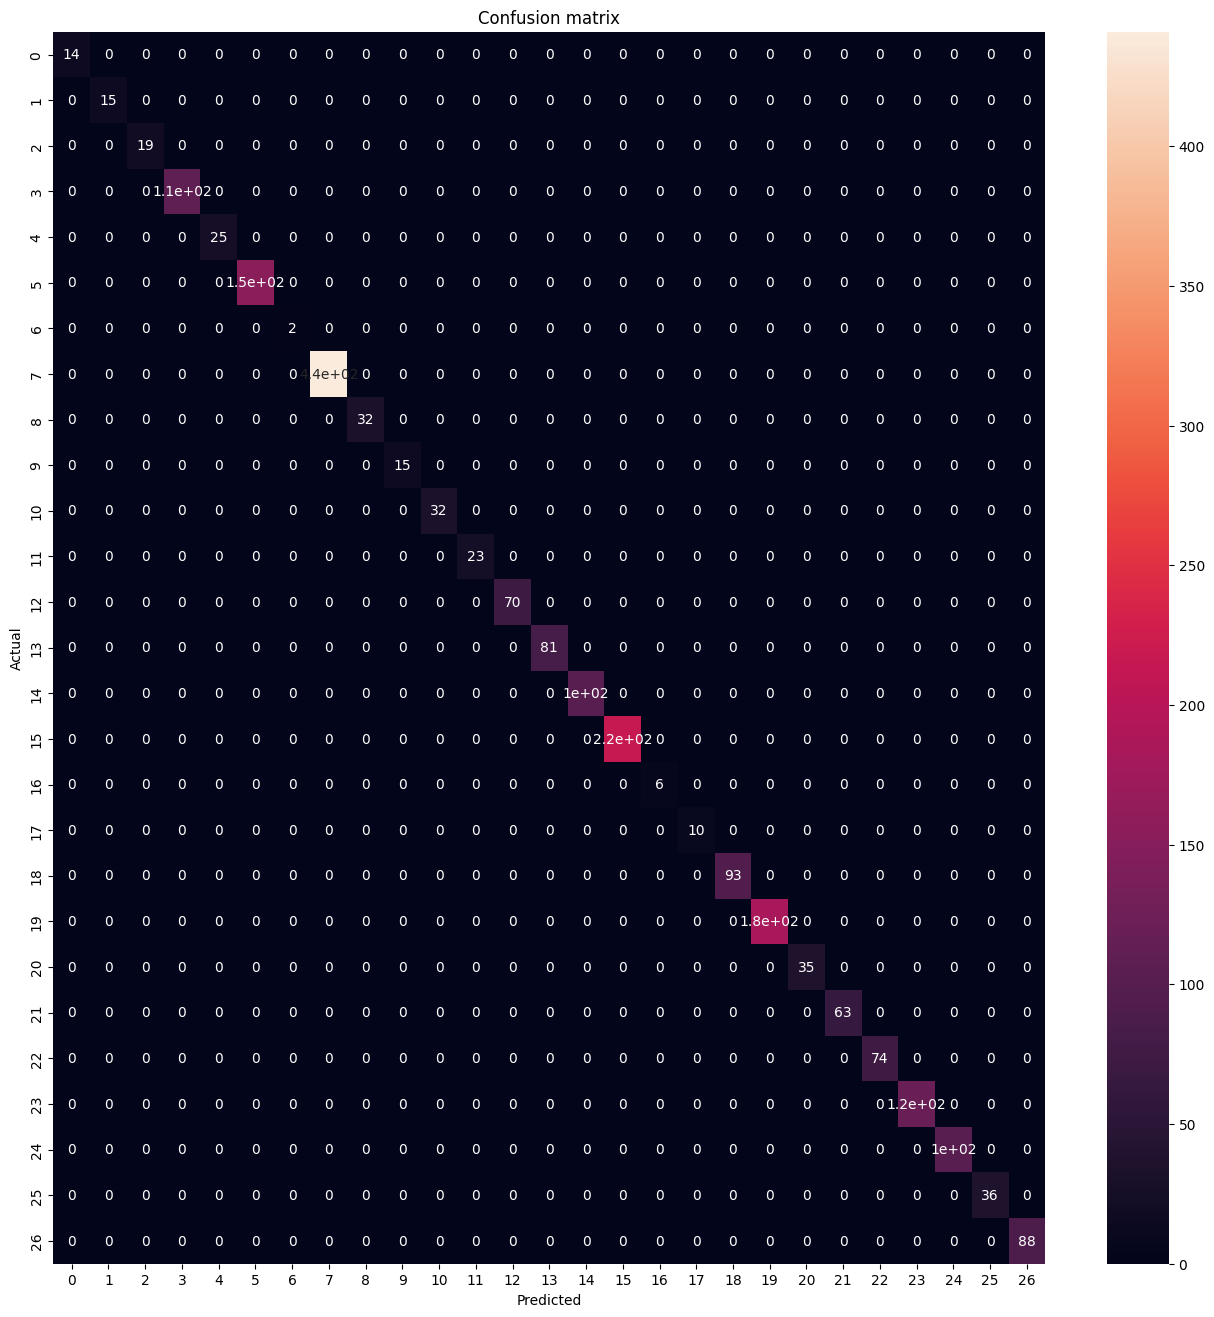

In [25]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(16,16))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

## Testing

In [26]:
inputs = tokenizer(["Please how do i go about the account creation? ",
                    "After setting up my account, i feel like i need to change it. How do i go about that?",
                    "how do i know how much i need to pay?",
                    "purchased a product, which i now want to change"
                    ], padding=True,return_tensors="tf")

logits = model(**inputs).logits
outputs=tf.argmax(logits,axis=-1).numpy()

In [27]:
print(outputs)

[ 0  2 20 26]


In [28]:
reverse_dict_intents={i:intents[i] for i in range(len(intents))}
print(reverse_dict_intents)

{0: 'registration_problems', 1: 'delivery_period', 2: 'edit_account', 3: 'track_order', 4: 'newsletter_subscription', 5: 'get_invoice', 6: 'cancel_order', 7: 'payment_issue', 8: 'delivery_options', 9: 'change_shipping_address', 10: 'track_refund', 11: 'switch_account', 12: 'review', 13: 'delete_account', 14: 'contact_human_agent', 15: 'create_account', 16: 'place_order', 17: 'set_up_shipping_address', 18: 'recover_password', 19: 'contact_customer_service', 20: 'check_payment_methods', 21: 'check_refund_policy', 22: 'complaint', 23: 'check_invoices', 24: 'get_refund', 25: 'check_cancellation_fee', 26: 'change_order'}


In [29]:
for i in outputs:
  print(reverse_dict_intents[i])

registration_problems
edit_account
check_payment_methods
change_order
